In [ ]:
from gremlin_python.driver import client, serializer
import nest_asyncio
import ssl
import certifi

nest_asyncio.apply()
ssl_context = ssl.create_default_context(cafile=certifi.where())

# Replace these values with your Cosmos DB Gremlin endpoint and primary key
COSMOS_DB_ENDPOINT = 'wss://sherlock-ai-account.gremlin.cosmos.azure.com:443/'
COSMOS_DB_PRIMARY_KEY = ''
DATABASE = 'sherlock-db'
GRAPH = 'sherlock-ai-graph'

# Create a connection to the Cosmos DB Gremlin endpoint
gremlin_client = client.Client(
    COSMOS_DB_ENDPOINT,
    'g',
    username=f"/dbs/{DATABASE}/colls/{GRAPH}",
    password=COSMOS_DB_PRIMARY_KEY,
    message_serializer=serializer.GraphSONSerializersV2d0(),
    ssl_context=ssl_context
)

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv('../../chicago_crime_data_with_names.csv')

In [68]:
def execute_batch(gremlin_client, queries):
    query = "g" + "".join(queries)
    try:
        gremlin_client.submitAsync(query).result().all().result()
    except Exception as e:
        print(f"Error executing query: {query}\n{e}")

In [69]:
cache_vertices = {}

In [70]:
def generate_query_vertex(label, id, properties):
    if cache_vertices.get(id):
        return None
    props = "".join([f".property('{k}', '{v}')" for k, v in properties.items()])
    query = f".addV('{label}').property(id, '{id}'){props}"
    cache_vertices[id] = 1
    return query

In [5]:
df_sample = df.sample(n=70000, random_state=42)

In [73]:
def batch_insert_crime_graph_vertices(gremlin_client, batch_size):
    vertex_queries = []

    for _, row in df_sample.iterrows():
        crime_id = str(row["ID"])
        location = row.get("Block", "Unknown")
        crime_type = row.get("Primary Type", "Unknown")
        criminal = row.get("Criminal", "Unknown")
        district = str(row.get("District", "Unknown"))
        on_date = str(row.get("Date", "Unknown"))
        hour = str(int(pd.to_datetime(on_date).hour))
        on_date = on_date.replace("/", "-").replace(":", "-").replace(" ", "_")

        # Build vertex queries
        for label, id, properties in [("crime", crime_id, {"crime_id": crime_id,"crime_type": crime_type}),
                                      ("location", location, {"location": location,"crime_type": crime_type}),
                                      ("crime_type", crime_type, {"crime_type": crime_type}),
                                      ("criminal", criminal, {"name": criminal,"crime_type": crime_type}),
                                      ("district", district, {"district": district,"crime_type": crime_type}),
                                      ("date", on_date, {"date": on_date,"crime_type": crime_type}),
                                      ("hour", hour, {"hour": hour,"crime_type": crime_type})]:
            query = generate_query_vertex(label, id, properties)
            if query:
                vertex_queries.append(query)

        # When batch size is reached, flush queries
        if len(vertex_queries) >= batch_size:
            execute_batch(gremlin_client, vertex_queries)
            vertex_queries.clear()

    if vertex_queries:
        execute_batch(gremlin_client, vertex_queries)

    print("✅ Graph Vertices insertion complete.")


In [74]:
batch_insert_crime_graph_vertices(gremlin_client, 50)

✅ Graph Vertices insertion complete.


In [79]:
def generate_query_edge(from_id, to_id, label):
    return f".addE('{label}').from(g.V('{from_id}')).to(g.V('{to_id}'))"

In [80]:
def batch_insert_crime_graph_edge(gremlin_client, df, batch_size):
    edge_queries = []
    for _, row in df_sample.iterrows():
        crime_id = str(row["ID"])
        location = row.get("Block", "Unknown")
        crime_type = row.get("Primary Type", "Unknown")
        criminal = row.get("Criminal", "Unknown")
        district = str(row.get("District", "Unknown"))
        on_date = str(row.get("Date", "Unknown"))
        hour = str(int(pd.to_datetime(on_date).hour))
        on_date = on_date.replace("/", "-").replace(":", "-").replace(" ", "_")

        edge_queries.append(generate_query_edge(crime_id, location, "located_at"))
        edge_queries.append(generate_query_edge(crime_id, crime_type, "is_type"))
        edge_queries.append(generate_query_edge(crime_id, hour, "occurred_at_hour"))
        edge_queries.append(generate_query_edge(crime_id, on_date, "occurred_on_date"))
        edge_queries.append(generate_query_edge(crime_id, criminal, "involved_criminal"))
        edge_queries.append(generate_query_edge(crime_id, district, "located_in_district"))

        # When batch size is reached, flush queries
        if len(edge_queries) >= batch_size:
            execute_batch(gremlin_client, edge_queries)
            edge_queries.clear()
    
    if edge_queries:
        execute_batch(gremlin_client, edge_queries)

In [81]:
batch_insert_crime_graph_edge(gremlin_client, df, 50)

In [100]:
from SherlockAI.CosmosGremlinGraph.GremlinGraph import GremlinGraph

graph = GremlinGraph(
    url=COSMOS_DB_ENDPOINT,
    username=f"/dbs/{DATABASE}/colls/{GRAPH}",
    password=COSMOS_DB_PRIMARY_KEY,
    ssl_context=ssl_context
)

print(f"Number of vertices are : {graph.query('g.V().count()')[0]}")
print(f"Number of edges are : {graph.query('g.E().count()')[0]}")

Number of vertices are : 160458
Number of edges are : 420000


In [6]:
import networkx as nx

G = nx.Graph()

for _, row in df_sample.iterrows():
    crime_id = str(row["ID"])
    location = row.get("Block", "Unknown")
    crime_type = row.get("Primary Type", "Unknown")
    criminal = row.get("Criminal", "Unknown")
    district = str(row.get("District", "Unknown"))
    on_date = str(row.get("Date", "Unknown"))
    hour = str(int(pd.to_datetime(on_date).hour))
    on_date = on_date.replace("/", "-").replace(":", "-").replace(" ", "_")

    # Add nodes
    G.add_node(crime_id, crime_id=crime_id, crime_type=crime_type)
    G.add_node(location, location=location, crime_type=crime_type)
    G.add_node(crime_type, crime_type=crime_type)
    G.add_node(on_date, date=on_date, crime_type=crime_type)
    G.add_node(hour, hour=hour, crime_type=crime_type)
    G.add_node(criminal, name=criminal, crime_type=crime_type)
    G.add_node(district, district=district, crime_type=crime_type)

    # Add edges
    G.add_edge(crime_id, location, relationship="located_at")
    G.add_edge(crime_id, crime_type, relationship="is_type")
    G.add_edge(crime_id, hour, relationship="occurred_at_hour")
    G.add_edge(crime_id, on_date, relationship="occurred_on_date")
    G.add_edge(crime_id, criminal, relationship="involved_criminal")
    G.add_edge(crime_id, district, relationship="located_in_district")

print(G)

Graph with 160458 nodes and 420000 edges


In [7]:
nx.config.warnings_to_ignore.add("cache")

# Check number of connected components
num_components = nx.number_connected_components(G)
print(f"Number of connected components: {num_components}")

# Get the size of the largest component
largest_component = max(nx.connected_components(G), key=len)
print(f"Size of the largest component: {len(largest_component)}")

Number of connected components: 1
Size of the largest component: 160458


In [8]:
degree_centrality = nx.degree_centrality(G)
top_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top nodes by degree centrality:")
for node, centrality in top_nodes:
    print(f"Node {node}: {centrality:.4f}")

Top nodes by degree centrality:
Node THEFT: 0.1020
Node BATTERY: 0.0816
Node CRIMINAL DAMAGE: 0.0484
Node 11.0: 0.0309
Node ASSAULT: 0.0302


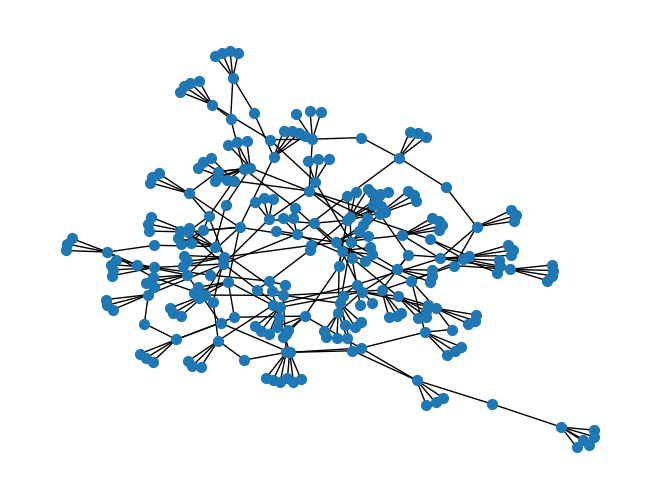

In [14]:
import matplotlib.pyplot as plt

# Create a subgraph of the first 200 nodes
subgraph = G.subgraph(list(G.nodes)[:250])

# Draw the subgraph
pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos, with_labels=False, node_size=50, font_size=8)
plt.show()